# Zernike 2D descriptors

Zernike polynomials of order $n, m \in \mathbb{Z}$ reads

$
\begin{align}
Z_{n}^{m}(r, \theta) = R_{n}^{m}(r) Y^{m}(\theta),
\end{align}
$

where $(r, \theta)$ are polar coordinates, $R_{n}^{m}(r)$ is radial Zernike polynomials

$
R_{n}^{m}(r) = \sum_{k = 0}^{(n - m) / 2} \dfrac{ (-1)^k (n - k)! }{k! (\dfrac{n + m}{2} - k)! (\dfrac{n - m}{2} - k)!} r^{n - 2 k},
$
and $Y^{m}(\theta)$ is azimuthal part
$
Y^{m}(\theta) = \Big \{
\begin{array}{ll}
\sin \theta |m|, \quad m < 0 \\
\cos \theta m, \quad m >= 0
\end{array}
$

Zernike polynomials $Z_{n}^{m}(r, \theta)$ form the complete orthonormal basis.
Any quadratically integrable function $f(x, y)$ defined on the unit disk $\{f : x^2 + y^2 \leq 1\}$ can ber expanded in this basis with following coefficients

$
c_{nm} = \dfrac{1 + n}{\pi} \int_{x^2 + y^2 \leq 1} f(x, y) Z_{n}^{m}(\sqrt{x^2 + y^2}, \arctan{x / y}) \mathrm{d}x \mathrm{d}y
$

In case of discrete image $f(x, y) = I(i, j), i,j \in \mathbb{Z}$

$
c_{nm} = \dfrac{1 + n}{N} \sum_{i, j} I(i, j)  Z_{n}^{m}(\sqrt{x_i^2 + y_j^2}, \arctan{x_i / y_j})
$

where $N$ is number of pixels inside the unit disk.

### References

[A. Khotanzad and Y. H. Hong, “Invariant image recognition by Zernike moments”](http://optics.sgu.ru/~ulianov/Bazarova/LASCA_literature/InvariantImageRecognitionZernikeMoments.pdf)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import factorial as fact
from math import sin, cos, atan2

In [20]:
class Zernike2D:
    def __init__(self, IMG: np.array):
        self.IMG_init = IMG  # unmodified image for display 
        self.IMG = np.dot(IMG[...,:3] / 255, [0.2989, 0.5870, 0.1140])  # grayscale image for calculations
    
    def checknm(self, n: int, m: int):
        """Chech the correctness of order n and m for Zernike moment."""
        if n < m: 
            raise InvalidZernikePolyOrder(f'n={n} and m={m} are invalid, n must be larger than m.')
        if (n - m) % 2 != 0:
            raise InvalidZernikePolyOrder(f'n={n} and m={m} are invalid, (n - m) must be an even number.')

    def radial(self, n: int, m: int) -> ():
        """Radial Zernike polynomials."""
        # check input parameters
        self.checknm(n, m)
        # numeric coeff
        N = lambda k: (-1)**k * fact(n - k) / (fact(k) * fact((n + m) / 2 - k) * fact((n - m) / 2 - k))

        if (n - m) % 2 != 0: 
            return lambda r: 0
        else:
            return lambda r: sum([N(k) * r**(n - 2 * k) for k in range((n - m) // 2 + 1)])
    
    def moment(self, n: int, m: int) -> ():
        """Zernike 2D moment, radial + azimuthal part for given order n."""
        # check input parameters
        self.checknm(n, m) 
        # init radial Zernike polynom of given order
        R = self.radial(abs(n), abs(m))
        # define the moment function
        def Z(x, y):
            if x**2 + y**2 > 1:
                return 0
            else:
                return R((x**2 + y**2)**0.5) * (sin(abs(m) * atan2(y, x)), cos(abs(m) *  atan2(y, x)))[m >= 0]
        return Z
        # return lambda x, y: (R((x**2 + y**2)**0.5) * (sin(abs(m) * atan2(y, x)), cos(abs(m) *  atan2(y, x)))[m >= 0], 0)[x**2 + y**2 > 1] 

    def descriptor(self, n: int) -> list:
        """Make Zernike 2D descriptor for given order n."""
        vector = []
        max_y, max_x = self.IMG.shape[:2] # max_y, max_x must be odd to symmetrically discretize moment
        dx = 2 / (max_x - 1)
        dy = 2 / (max_y - 1)
        # determine grid for moment discretization
        x, y = np.arange(-1, 1 + dx, dx), np.arange(-1, 1 + dx, dy)
        # determine normalization factor: number of pixel within the unit disk i.e. number of nonzero pixels of moment 0,0
        A00 = np.array([[self.moment(0, 0)(xi, yi) for xi in x] for yi in y])
        NA00 = np.count_nonzero(A00)

        for i in range(n):
            for j in range(-i, i + 1, 2):
                A = np.array([[self.moment(i, j)(xi, yi) for xi in x] for yi in y])
                # plt.imshow(A)
                # plt.show()
                component = (i, j, (i + 1) * np.sum(self.IMG * A) / NA00)
                vector.append(component)

        return vector

    def reconstruct(self, descriptor: list):
        """Reconstruct image from the descriptor composed of Zernike moments."""
        # descriptor [(n, m, Anm)]
        max_y, max_x = self.IMG.shape[:2] # max_y, max_x must be odd to symmetrically discretize
        dx = 2 / (max_x - 1)
        dy = 2 / (max_y - 1)
        res = np.zeros((max_y, max_x))

        x, y = np.arange(-1, 1 + dx, dx), np.arange(-1, 1 + dy, dy)
        
        for n, m, coeff in descriptor:
            res += coeff * np.array([[self.moment(n, m)(xi, yi) for xi in x] for yi in y]) 

        plt.figure(dpi=100)
        plt.subplot(1,3,1)
        plt.title('Original')
        plt.imshow(self.IMG_init, cmap='gray')
        plt.subplot(1,3,2)
        plt.title('Reconstructed')
        plt.imshow(res, cmap='rainbow')
        plt.subplot(1,3,3)
        plt.title('Overlay')
        plt.imshow(self.IMG_init, cmap='gray')
        plt.imshow(res, cmap='rainbow', alpha=0.6)
        plt.show()
        
    def plot_radial(self, n: int, m: int):
        """Plot radial Zernike polynom of order n."""
        R = self.radial(n, m)
        x = np.arange(0, 1, 0.01)
        y = np.array([R(r) for r in x])

        plt.figure(dpi=100)
        plt.plot(x, y)
        plt.xlim(0, 1.1)
        plt.ylabel(f'$R_{n}^{m}(r)$')
        plt.xlabel('r')
        plt.show()

    def plot_moment(self, n: int, m: int):
        """Plot Zernike 2D moments for given order n."""
        Z = self.moment(n, m)
        d = 0.01
        x, y = np.arange(-1, 1 + d, d), np.arange(-1, 1 + d, d)
        z = np.array([[Z(xi, yi) for xi in x] for yi in y])
        
        plt.figure(dpi=100)
        plt.title(f'Z_{n}^{m}')
        plt.imshow(z, cmap='rainbow')
        plt.show()
    
    def test_orthogonality(self, n1: int, m1: int, n2: int, m2: int):
        """Calculate Zernike descriptor for two moments: (n1,m1), (n2,m2)."""
        Z1 = self.moment(n1, m1)
        Z2 = self.moment(n2, m2)

        d = 0.005
        x, y = np.arange(-1, 1 + d, d), np.arange(-1, 1 + d, d)
        # determine normalization factor: number of pixel within the unit disk i.e. number of nonzero pixels of moment 0,0
        A00 = np.array([[self.moment(0, 0)(xi, yi) for xi in x] for yi in y])
        NA00 = np.count_nonzero(A00)

        z1 = np.array([[Z1(xi, yi) for xi in x] for yi in y])
        z2 = np.array([[Z2(xi, yi) for xi in x] for yi in y])

        print(f'Z_{n1}^{m1} * Z_{n2}^{m2} == {(n1 + 1) * np.sum(z1 * z2) / NA00}')

class InvalidZernikePolyOrder(Exception):
    pass

In [16]:
test_img = plt.imread('imgs/peafowl.jpg')


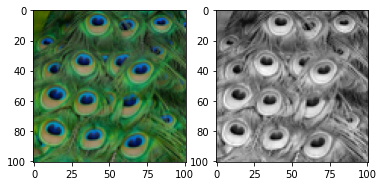

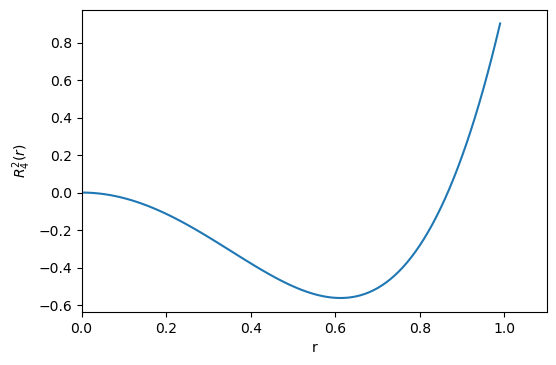

In [21]:
zen = Zernike2D(test_img)

plt.subplot(1,2,1)
plt.imshow(zen.IMG_init)
plt.subplot(1,2,2)
plt.imshow(zen.IMG, cmap='gray')
plt.show()

zen.plot_radial(4, 2)
# zen.plot_moment(4, 2)


In [18]:
descr = zen.descriptor(15)

#for d in descr:
#    print(d)

120


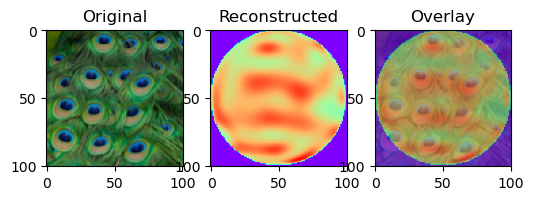

In [22]:
print(len(descr))
zen.reconstruct(descr)

In [69]:
d = 0.01
x, y = np.arange(-1, 1 + d, d), np.arange(-1, 1 + d, d)

m00 = np.array([[zen.moment(0, 0)(xi, yi) for xi in x] for yi in y]) # moment 0,0 

print(np.count_nonzero(m00) / ((len(x) - 1)/ 2)**2)
print(np.pi)

# plt.imshow(m00)

3.1403
3.141592653589793


In [ ]:
zen.test_orthogonality(2, 0, 2, 0)
zen.test_orthogonality(2, 0, 0, 0)
zen.test_orthogonality(2, 0, 1, 1)
zen.test_orthogonality(2, 0, 3, 1)
zen.test_orthogonality(2, 0, 2, 2)
zen.test_orthogonality(2, 0, 12, 2)
